In [97]:
import sys
sys.path.append("/cellarold/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/gcta/scripts')

In [98]:
from compile_gcta_df import *

In [99]:
#data
import os
import json
import pandas as pd
import numpy as np

In [100]:
#statistics
import scipy
from scipy import stats
import statsmodels.stats.multitest as multi
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from regressors import stats
import statsmodels.api as sm

In [101]:
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import ndex2
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import networkx as nx

In [105]:
def calc_pearson(file):
    
    '''
    calculate pearson correlation matrix from plink IP component dataframe
    '''
    
    pheno=pd.read_csv(file,delimiter="\t")
    del pheno["IID"]
    pheno=pheno.replace(-9, np.nan)
    pheno_corr=pheno.corr(method="pearson")
    return(pheno_corr)

In [103]:
def fdr(df,pseudo):
    
    '''
    calculate Benjamini-Hochberg FDR
    pseudo: True or False
    '''
    #make heritability estimate numeric
    df["V(G)/Vp"]=pd.to_numeric(df["V(G)/Vp"])
    #add pseudocount
    if pseudo == True:
        df["Pval"]=df["Pval"]+0.0000001
    
    #calculate benjamin-hochberg fdr
    genes=df["gene"].tolist()
    probabilities = df["Pval"].to_numpy()
    report = multi.multipletests(probabilities,
                alpha=0.05,
                method="fdr_bh",
                is_sorted=False,
            )
    discoveries = report[1]
    df["fdr"]=discoveries
    df["fdr"]=pd.to_numeric(df["fdr"])
    df["-log10(fdr)"]=-np.log10(df["fdr"])
    
    return(df)

### Get IP Components

In [106]:
pheno_folder="../data/downloaded_phenos/"

#antigen presentation genes
antigen_present=pd.read_csv(pheno_folder+"antigen_present_geneset.txt",skiprows=[1])
antigen_present_list=antigen_present["GO_ANTIGEN_PROCESSING_AND_PRESENTATION"].tolist()
antigen_present_list.append("MARCH1")

#immunomodulators
im_landscape=pd.read_csv(pheno_folder+"im-landscape-markers.txt",header=None)
im_landscape_list=im_landscape[0].tolist()

#cell type markers
danaher=pd.read_csv(pheno_folder+"danaher_markers.csv")
danaher_list=danaher["Gene"].tolist()

#immune checkpoint
im_checkpoint=pd.read_csv(pheno_folder+"immune-checkpoint.csv")
im_checkpoint_list=im_checkpoint["HGNC Symbol"].tolist()
im_checkpoint_list=[x for x in im_checkpoint_list if str(x) != "nan"]

#immune landscape components
landscape=pd.read_csv(pheno_folder+"pheno-immune-landscape-comp",delimiter="\t")
landscape_comps=landscape.columns[2:]

#IFN gamma
ifng=pd.read_csv(pheno_folder+"ifng-markers.txt",header=None)
ifng_list=ifng[0].tolist()

#TGF beta
tgfbeta=pd.read_csv(pheno_folder+"tgf-beta-markers.txt",header=None)
tgfbeta_list=tgfbeta[0].tolist()

#CIBERSORTx
cibersortx=pd.read_csv("../data/plink-associations/phenotypes/TCGA.Kallisto.fullIDs.cibersort.relative.tsv",delimiter="\t")
cibersortx_list=[x.replace(" ",".") for x in cibersortx.columns[2:-3]]

#map gene aliases
genes=pd.read_excel(pheno_folder+"PanImmune_GeneSet_Definitions.xlsx",sheet_name="Sheet2",header=None)
dict_alias={"CSPG2":"VCAN","CUGBP2":"CELF2","C16orf61":"CMC2","PSCDBP":"CYTIP","CD97":"ADGRE5","IGJ":"JCHAIN","C13orf27":"TEX30","CD8B1":"CD8B","C3orf26":"CMSS1","FPRL2":"FPR3","CD3Z":"CD247","C12orf24":"FAM216A","PTPLB":"HACD2","MLF1IP":"CENPU"}
genes["mapping"]=genes[1]
genes["mapping"]=genes["mapping"].replace(dict_alias)
mp_source=dict(zip(genes["mapping"],genes[0]))

#IP Component Dictionary Mapping
pheno_dict={}

for x in antigen_present_list:
    x=x.replace("-",".")
    pheno_dict[x]="antigen present"
for x in im_landscape_list:
    x=x.replace("-",".")
    pheno_dict[x]="immunomodulators"
for x in danaher_list:
    x=x.replace("-",".")
    pheno_dict[x]="cell type"
for x in im_checkpoint_list:
    x=x.replace("-",".")
    pheno_dict[x]="immune checkpoint"
for x in landscape_comps:
    x=x.replace("-",".")
    pheno_dict[x]="landscape components"
for x in ifng_list:
    x=x.replace("-",".")
    pheno_dict[x]="IFNG"    
for x in tgfbeta_list:
    x=x.replace("-",".")
    pheno_dict[x]="TGFbeta"
for x in cibersortx_list:
    x=x.replace("-",".")
    pheno_dict[x]="immune infiltration"

#force HLA genes to be in antigen-presentation group
for x in pheno_dict.keys():
    if "HLA" in x:
        pheno_dict[x]="antigen present"

print(len(pheno_dict))

with open('../data/pheno_dictionary.json', 'w') as json_file:
    json.dump(pheno_dict, json_file)

print(len(set(antigen_present_list)))
print(len(set(im_landscape_list)))
print(len(set(danaher_list)))
print(len(set(im_checkpoint_list)))
print(len(set(landscape_comps)))
print(len(set(ifng_list)))
print(len(set(tgfbeta_list)))
print(len(set(cibersortx_list)))

794
228
436
60
78
6
6
19
22


In [107]:
pheno_map=pd.DataFrame(pheno_dict,index=[0])
pheno_map=pheno_map.T
pheno_map=pheno_map.reset_index().rename(columns={"index":"IP component"})
pheno_map["source"]=pheno_map["IP component"].map(mp_source)
pheno_map.to_csv("../tables/supplementary_table_1.csv",header=None)

In [108]:
#get phenotypes
final_pheno=pd.read_csv("../tables/supplementary_table_2.csv", nrows=0).columns[2:]
pheno_map["filter"]=np.where(pheno_map["IP component"].isin(final_pheno),"","filtered out")
pheno_map.columns=["IP component","category","source","filter"]
pheno_map.to_csv("../tables/supplemental_table_1.csv",header=None)

### Run Pearson Correlation

In [109]:
pearson=calc_pearson("../tables/supplementary_table_2.csv")

### Run GCTA

see script: **run-gcta.sh**

Run GREML analysis for all immune phenotypes

### Get GCTA results

In [110]:
pseudocount=True
results=[""]

pancan=compile_gcta_results(results,output="overall",direct="../data/gcta/greml/full")
pancan=fdr(pancan,pseudocount)
pancan=pancan.sort_values(by="fdr")
gcta_genes=pancan[pancan["V(G)/Vp"]>0.05]["gene"].tolist()

compiling gene level heritability dataframe.....


/cellar/users/mpagadal/scripts/gcta/compile_gcta_df.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  variance["V(G) SE"]=se[0].tolist()
/cellar/users/mpagadal/scripts/gcta/compile_gcta_df.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  variance["V(e) SE"]=se[1].tolist()
/cellar/users/mpagadal/scripts/gcta/compile_gcta_df.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

In [111]:
print(len(gcta_genes))

235


### Plot Pearon Correlation Matrix

<Figure size 1080x720 with 0 Axes>

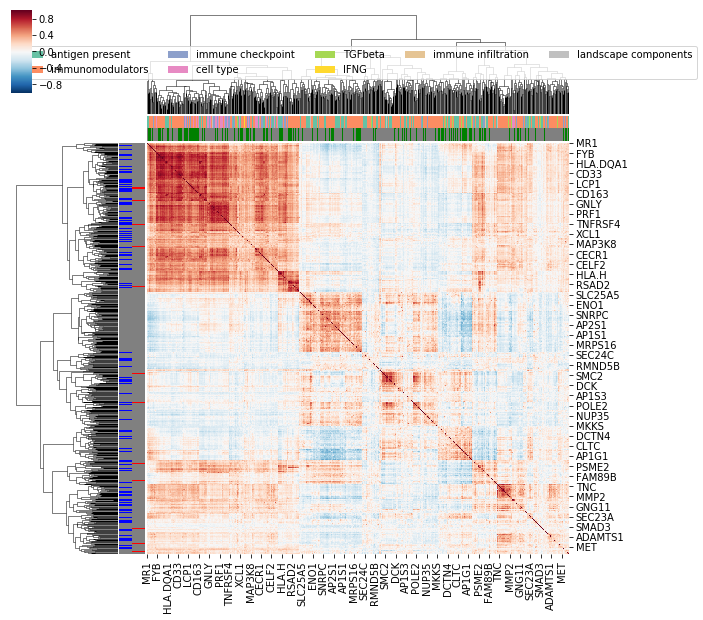

In [112]:
# color by IP component category
color_category={"#66c2a5":"antigen present","#fc8d62":"immunomodulators","#8da0cb":"immune checkpoint","#e78ac3":"cell type","#a6d854":"TGFbeta","#ffd92f":"IFNG","#e5c494":"immune infiltration","silver":"landscape components"}
category_color=dict((y,x) for x,y in color_category.items())
pheno_color=[category_color[pheno_dict[x.replace("-",".")]] for x in pearson.columns]

#color by GCTA heritability
gcta_color=["green" if x in gcta_genes else "gray" for x in pearson.columns]

# color by protein atlas annotation
atlas=pd.read_csv("../data/proteinatlas/proteinatlas.tsv",delimiter="\t")
immune_specificity=atlas[atlas["RNA blood cell specificity"].isin(["Cell type enhanced","Cell type enriched","Group enriched "])]["Gene"].tolist()
cancer_specificity=atlas[atlas["RNA cancer specificity"].isin(["Cancer enhanced","Cancer enriched","Group enriched "])]["Gene"].tolist()
immune_color=["blue" if x in immune_specificity else "gray" for x in pearson.columns]
cancer_color=["red" if x in cancer_specificity else "gray" for x in pearson.columns]

# plot clustermap

fig = plt.figure(figsize=(15,10))
g=sns.clustermap(pearson,vmin=-1,cmap="RdBu_r", col_colors = [pheno_color,gcta_color], row_colors=[immune_color,cancer_color])
for label in category_color.keys():
    g.ax_col_dendrogram.bar(0, 0, color=category_color[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
plt.savefig('../plots/fig1/pancan_pheno_clustermap.pdf',dpi=300)


### Get GCTA results for nonhla/hla

In [113]:
#nonhla 2-state GCTA results
nonhla=compile_gcta_results(results,output="overall",direct="../data/gcta/greml/no-hla-kir")
nonhla=nonhla[nonhla["gene"].isin(gcta_genes)]
nonhla=fdr(nonhla,pseudocount)

#hla 2-state GCTA results
hla=compile_gcta_results(results,output="overall",direct="../data/gcta/greml/hla-kir")
hla=hla[hla["gene"].isin(gcta_genes)]
hla=fdr(hla,pseudocount)

compiling gene level heritability dataframe.....


/cellar/users/mpagadal/scripts/gcta/compile_gcta_df.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  variance["V(G) SE"]=se[0].tolist()
/cellar/users/mpagadal/scripts/gcta/compile_gcta_df.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  variance["V(e) SE"]=se[1].tolist()
/cellar/users/mpagadal/scripts/gcta/compile_gcta_df.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

compiling gene level heritability dataframe.....


In [114]:
nonhla_genes=nonhla[(nonhla["fdr"]<.05)]["gene"].tolist()
hla_genes=hla[(hla["fdr"]<.05)]["gene"].tolist()

In [116]:
print("{} heritable IP components outside HLA region".format(len(nonhla_genes)))

144 heritable IP components outside HLA region


In [117]:
print("{} heritable IP components in HLA region".format(len(hla_genes)))

17 heritable IP components in HLA region


### Make HLA-nonHLA GCTA dataframe

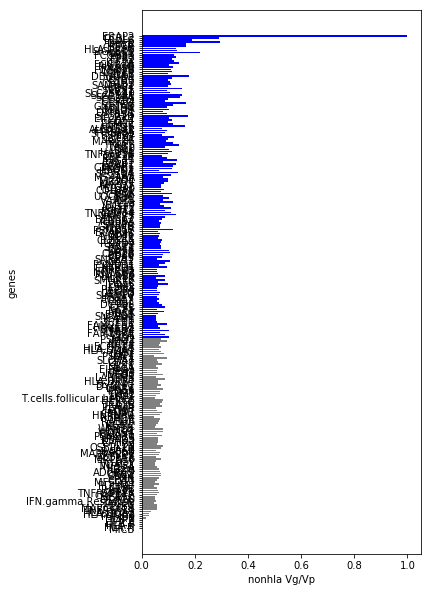

In [118]:
plot_nonhla=nonhla.sort_values(by="fdr",ascending=False)
plot_nonhla=plot_nonhla[plot_nonhla["gene"].isin(gcta_genes)]
plot_nonhla.shape

plot_nonhla["color"]=np.where(plot_nonhla["fdr"]<.05,"blue","gray")

fig, ax = plt.subplots(figsize=(5,10))

for x in plot_nonhla["color"].unique():
    ax.barh(plot_nonhla[plot_nonhla["color"]==x]["gene"],plot_nonhla[plot_nonhla["color"]==x]["V(G)/Vp"],color=x)
plt.ylabel("genes")
plt.xlabel("nonhla Vg/Vp")
plt.savefig("../plots/fig1/gcta.nonhla.pdf")

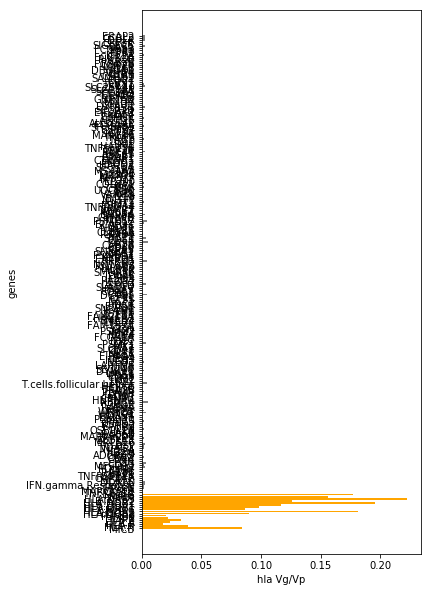

In [119]:
plot_hla=hla[hla["gene"].isin(gcta_genes)]
plot_hla.shape
plot_hla=plot_hla.set_index("gene")
plot_hla=plot_hla.loc[plot_nonhla["gene"].tolist()]

plot_hla["color"]=np.where(plot_hla["fdr"]<.05,"orange","gray")

fig, ax = plt.subplots(figsize=(5,10))

for x in plot_hla["color"].unique():
    ax.barh(plot_hla[plot_hla["color"]==x].index,plot_hla[plot_hla["color"]==x]["V(G)/Vp"],color=x)
plt.ylabel("genes")
plt.xlabel("hla Vg/Vp")
plt.savefig("../plots/fig1/gcta.hla.pdf")

In [120]:
#compile GCTA results
gcta=pancan[["gene","V(G)/Vp","Pval","fdr","n"]].sort_values(by="fdr")
gcta.columns=["gene","full V(G)/Vp","full Pval","full fdr","full n"]
gcta=pd.merge(gcta,nonhla[["gene","V(G)/Vp","Pval","fdr"]],on="gene",how="left")
gcta.columns=["gene","full V(G)/Vp","full Pval","full fdr","full n","nonhla V(G)/Vp","nonhla Pval","nonhla fdr"]
gcta=pd.merge(gcta,hla[["gene","V(G)/Vp","Pval","fdr"]],on="gene",how="left")
gcta.columns=["gene","full V(G)/Vp","full Pval","full fdr","full n","nonhla V(G)/Vp","nonhla Pval","nonhla fdr","hla V(G)/Vp","hla Pval","hla fdr"]
gcta.to_csv("../tables/supplementary_table_3.csv",index=None,sep="\t")

### Get CIBERSORTx TCGA distribution

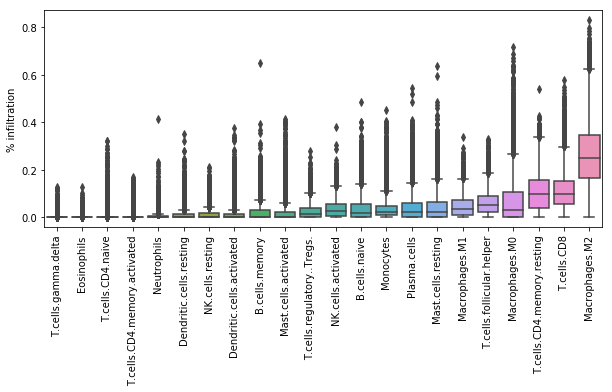

In [121]:
ciber_lm22=pd.read_csv("../data/plink-associations/phenotypes/TCGA.Kallisto.fullIDs.cibersort.relative.tsv",delimiter="\t")
ciber_lm22["id"]=ciber_lm22["SampleID"].str.replace(".","-")
ciber_lm22["code"]=ciber_lm22["id"].str.rsplit("-",4).str[1]
ciber_lm22["id"]=ciber_lm22["id"].str.rsplit("-",4).str[0]
ciber_lm22=ciber_lm22[ciber_lm22["code"].str.contains("01")]
ciber_lm22.index=ciber_lm22["id"]
ciber_lm22=ciber_lm22[ciber_lm22.columns[2:-5].tolist()]
ciber_lm22=ciber_lm22.groupby(ciber_lm22.index).mean()
ciber_lm22=ciber_lm22.reset_index().rename(columns={"id":"IID"})

fam=pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",delim_whitespace=True,header=None)
ciber_lm22_fam=ciber_lm22[ciber_lm22["IID"].isin(fam[0].tolist())]

ciber_melt=pd.melt(ciber_lm22_fam, id_vars=['IID'], value_vars=ciber_lm22_fam.columns.tolist()[1:])
order=ciber_melt.groupby("variable").mean().sort_values(by="value").index.tolist()

fig = plt.figure(figsize=(10,4))
sns.boxplot(x="variable",y="value",data=ciber_melt,order=order)
plt.xticks(rotation=90)
plt.ylabel("% infiltration")
plt.xlabel("")
plt.savefig("../plots/fig1/tcga.infiltration.pdf")

### Run PCA analysis with GCTA phenotypes

In [122]:
def pca(df):
    
    '''
    input dataframe (df) and return PCs
    '''
    
    #scale data
    scaler=StandardScaler()
    scaler.fit(df) 
    X_scaled=scaler.transform(df)
    
    #conduct PCA with 30 compoenents
    pca = PCA(n_components=30)
    pca.fit(X_scaled)
    
    #get variance explained
    mp_variance={}

    for i,val in enumerate(pca.explained_variance_ratio_.tolist()):
        key="PC"+str(i+1)
        mp_variance[key]=val
    
    #get PCA dataframes
    X_pca=pca.transform(X_scaled)
    df_pca=pd.DataFrame(X_pca)
    df_pca.index=df.index
    df_pca.columns=["PC"+str(x+1) for x in df_pca.columns]
    df_pca=df_pca.reset_index()
    df_pca=df_pca.rename(columns={"index":"FID"})
    
    #get loadings
    loadings = pd.DataFrame(pca.components_.T)
    loadings.index=df.columns
    loadings.columns=["PC"+str(x+1) for x in loadings.columns]
    
    return df_pca, mp_variance, loadings

In [123]:
pancanatlas=pd.read_csv("../tables/supplementary_table_2.csv",delimiter="\t")
pancanatlas=pancanatlas.replace(-9,np.nan)
pancanatlas=pancanatlas.dropna(how='any')
del pancanatlas["IID"]
pancanatlas=pancanatlas.set_index("FID")

print(pancanatlas[[x for x in nonhla_genes if x not in hla_genes]+hla_genes].shape)
gcta_pca, gcta_var, gcta_loadings=pca(pancanatlas[[x for x in nonhla_genes if x not in hla_genes]+hla_genes])

loadings_gene_list=[]

for x in range(1,21):
    loadings_gene_list=loadings_gene_list+gcta_loadings.sort_values(by="PC"+str(x)).index.tolist()[0:3]
    loadings_gene_list=loadings_gene_list+gcta_loadings.sort_values(by="PC"+str(x)).index.tolist()[-3:]
    
all_pheno=pd.merge(pancanatlas.reset_index(),gcta_pca,on="FID",how="left")

pc=[]
pheno=[]
beta=[]
pval=[]

for x in range(1,11):
    for p in set(loadings_gene_list):
        ols = linear_model.LinearRegression()
        X=all_pheno[p].values.reshape(-1, 1)
        y=all_pheno["PC"+str(x)].values.reshape(-1, 1)
        
        X = sm.add_constant(X)
        
        model=sm.OLS(y,X)
        results=model.fit()
        
        beta.append(results.params[1])
        pval.append(results.pvalues[1])
        pheno.append(p)
        pc.append("PC"+str(x))

df_ols=pd.DataFrame({"PC":pc,"pheno":pheno,"beta":beta,"p":pval})
df_ols["int"]=df_ols["PC"].str.split("PC").str[1]
df_ols["int"]=df_ols["int"].astype(int)
df_ols=df_ols.sort_values(by=["int",'pheno'],ascending=True)
df_ols["-log10p"]=-np.log10(df_ols["p"])
df_ols["-log10p"]=np.where(df_ols["-log10p"]>20,20,df_ols["-log10p"])

(6860, 157)


/cellar/users/mpagadal/Programs/miniconda3/envs/baseold/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


In [124]:
pc_lst=[]
neg_loading=[]
pos_loading=[]
for x in range(10):
    pc_lst.append("PC"+str(x+1))
    neg_loading.append(",".join(gcta_loadings.sort_values(by="PC"+str(x+1)).index.tolist()[0:3]))
    pos_loading.append(",".join(gcta_loadings.sort_values(by="PC"+str(x+1)).index.tolist()[-3:]))

In [125]:
supp_table7=pd.DataFrame({"PC":pc_lst,"Top 3 negative loadings":neg_loading,"Top 3 positive loadings":pos_loading})
supp_table7["var"]=supp_table7["PC"].map(gcta_var)
supp_table7.to_csv("../tables/supplementary_table_7.csv")

### Get Pearson correlation

In [126]:
#chose pancanatlas rna because it has all genes
pancanatlas=pd.read_csv("../tables/supplementary_table_2.csv",delimiter="\t")
pancanatlas=pancanatlas.replace(-9,np.nan)
pancanatlas=pancanatlas.dropna(how='any')
del pancanatlas["IID"]
pancanatlas=pancanatlas.set_index("FID")

print(pancanatlas[[x for x in nonhla_genes if x not in hla_genes]+hla_genes].shape)
gcta_pca, gcta_var, gcta_loadings=pca(pancanatlas[[x for x in nonhla_genes if x not in hla_genes]+hla_genes])
    
all_pheno=pd.merge(pancanatlas.reset_index(),gcta_pca,on="FID",how="left")

pearson_lst=[]
pheno_lst=[]

for x in pancanatlas.columns:
    pearson_lst.append(all_pheno["PC2"].corr(all_pheno[x],method="pearson"))
    pheno_lst.append(x)
    

(6860, 157)


In [127]:
df_pear=pd.DataFrame({"pheno":pheno_lst,"pearson":pearson_lst})

### Get clustermap of phenotypes

<Figure size 1440x1440 with 0 Axes>

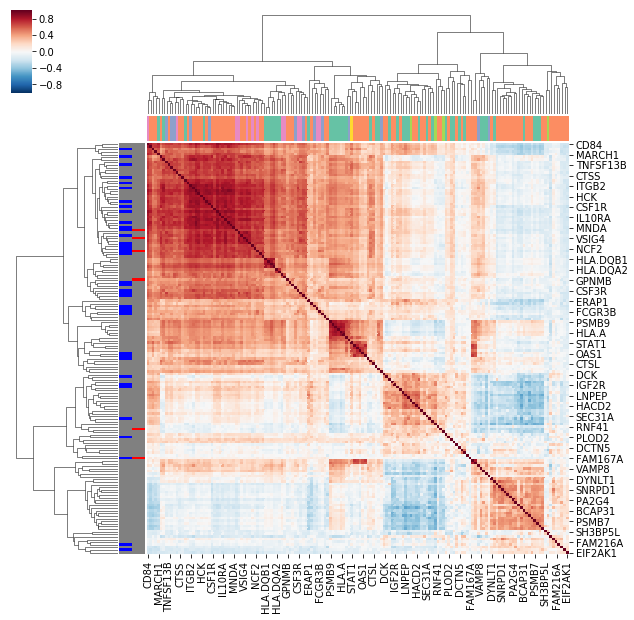

In [128]:
gcta_genes=[x for x in set(nonhla_genes+hla_genes)]

pearson_gcta=pearson[gcta_genes]
pearson_gcta=pearson_gcta.loc[gcta_genes]

immune_color=["blue" if x in immune_specificity else "gray" for x in pearson_gcta.columns]
cancer_color=["red" if x in cancer_specificity else "gray" for x in pearson_gcta.columns]

pheno_color=[category_color[pheno_dict[x.replace("-",".")]] for x in pearson_gcta.columns]

fig = plt.figure(figsize=(20,20))
g=sns.clustermap(pearson_gcta,vmin=-1,cmap="RdBu_r",col_colors = pheno_color,row_colors=[immune_color,cancer_color])
# for label in category_color.keys():
#  ../tables/x_col_dendrogram.bar(0, 0, color=category_color[label],
#                             label=label, linewidth=0)
# g.ax_col_dendrogram.legend(loc="center", ncol=5)


In [129]:
group1=g.data2d.columns.tolist()[0:88]
group2=g.data2d.columns.tolist()[88:]

In [130]:
col_color=[]

for x in pearson_gcta.columns:
    if x in group1:
        col_color.append("r")
    elif x in group2:
        col_color.append("g")

<Figure size 1440x1440 with 0 Axes>

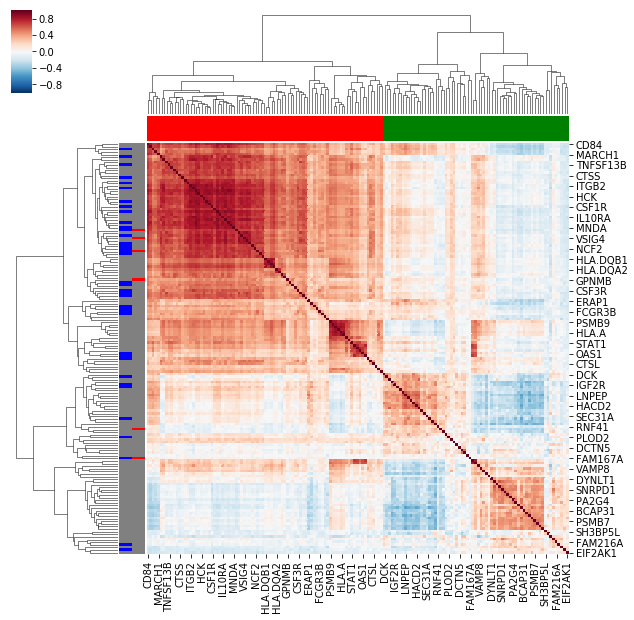

In [131]:
gcta_genes=[x for x in set(nonhla_genes+hla_genes)]

pearson_gcta=pearson[gcta_genes]
pearson_gcta=pearson_gcta.loc[gcta_genes]

immune_color=["blue" if x in immune_specificity else "gray" for x in pearson_gcta.columns]
cancer_color=["red" if x in cancer_specificity else "gray" for x in pearson_gcta.columns]

pheno_color=[category_color[pheno_dict[x.replace("-",".")]] for x in pearson_gcta.columns]

fig = plt.figure(figsize=(20,20))
g=sns.clustermap(pearson_gcta,vmin=-1,cmap="RdBu_r",col_colors = col_color,row_colors=[immune_color,cancer_color])
# for label in category_color.keys():
#     g.ax_col_dendrogram.bar(0, 0, color=category_color[label],
#                             label=label, linewidth=0)
# g.ax_col_dendrogram.legend(loc="center", ncol=5)
plt.savefig("../plots/fig1/pearson_correlation_gcta.pdf")

In [132]:
#get networkx plot

links=pearson_gcta.stack().reset_index()
links.columns=["node1","node2","value"]

links["color"]=np.where(links["value"]>0,"green","red")

# get significant edges

edges=links[(links["value"]>0.8)|(links["value"]<-0.4)]
edges=edges[edges["node1"]!=edges["node2"]]

#group1 plot

group1_lst=edges[(edges["node1"].isin(group1))|(edges["node2"].isin(group1))]["node1"].unique().tolist()+edges[(edges["node1"].isin(group1))|(edges["node2"].isin(group1))]["node2"].unique().tolist()
group1_edges=links[(links["node1"].isin(group1_lst))&(links["node2"].isin(group1_lst))]

G=nx.Graph()

for i,row in group1_edges.iterrows():
    if row["value"]>0.8:
        G.add_edge(row["node1"],row["node2"],width=abs(row["value"]),color="red")
    elif row["value"]<-0.4:
        G.add_edge(row["node1"],row["node2"],width=abs(row["value"]),color="blue")
    else:
        G.add_edge(row["node1"],row["node2"],width=abs(row["value"]),color="gray")

final = ndex2.create_nice_cx_from_networkx(G)
final.upload_to('http://public.ndexbio.org', username = 'meghanasp21', password = 'student16')

#group1 plot

group2_lst=edges[(edges["node1"].isin(group2))|(edges["node2"].isin(group2))]["node1"].unique().tolist()+edges[(edges["node1"].isin(group2))|(edges["node2"].isin(group2))]["node2"].unique().tolist()
group2_edges=links[(links["node1"].isin(group2_lst))&(links["node2"].isin(group2_lst))]

G=nx.Graph()

for i,row in group2_edges.iterrows():
    if row["value"]>0.8:
        G.add_edge(row["node1"],row["node2"],width=abs(row["value"]),color="red")
    elif row["value"]<-0.4:
        G.add_edge(row["node1"],row["node2"],width=abs(row["value"]),color="blue")
    else:
        G.add_edge(row["node1"],row["node2"],width=abs(row["value"]),color="gray")

final = ndex2.create_nice_cx_from_networkx(G)
final.upload_to('http://public.ndexbio.org', username = 'meghanasp21', password = 'student16')

ConnectionError: HTTPConnectionPool(host='public.ndexbio.org', port=80): Max retries exceeded with url: /rest/admin/status (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1555046b1be0>: Failed to establish a new connection: [Errno -2] Name or service not known'))

### make group node list

In [133]:
df_color=pd.DataFrame({"nodes":pearson_gcta.index.tolist()})
df_color["group"]=np.where(df_color["nodes"].isin(group1),"group1","group2")

In [134]:
df_color.to_csv("../data/networkx/networkx.group.csv",index=None)

### Get GO ontology analysis

In [135]:
go1=pd.read_csv("../data/go/group1_analysis.txt",skiprows=[0,1,2,3,4,5,6,7,8,9,10],delimiter="\t")

In [136]:
go2=pd.read_csv("../data/go/group2_analysis.txt",skiprows=[0,1,2,3,4,5,6,7,8,9,10],delimiter="\t")

In [137]:
go1["upload_1 (fold Enrichment)"]=go1["upload_1 (fold Enrichment)"].str.replace("> ","").astype(float)
go2["upload_1 (fold Enrichment)"]=go2["upload_1 (fold Enrichment)"].astype(str).str.replace("> ","").astype(float)

In [138]:
go1_plot=go1.sort_values(by="upload_1 (fold Enrichment)",ascending=False).iloc[0:10]

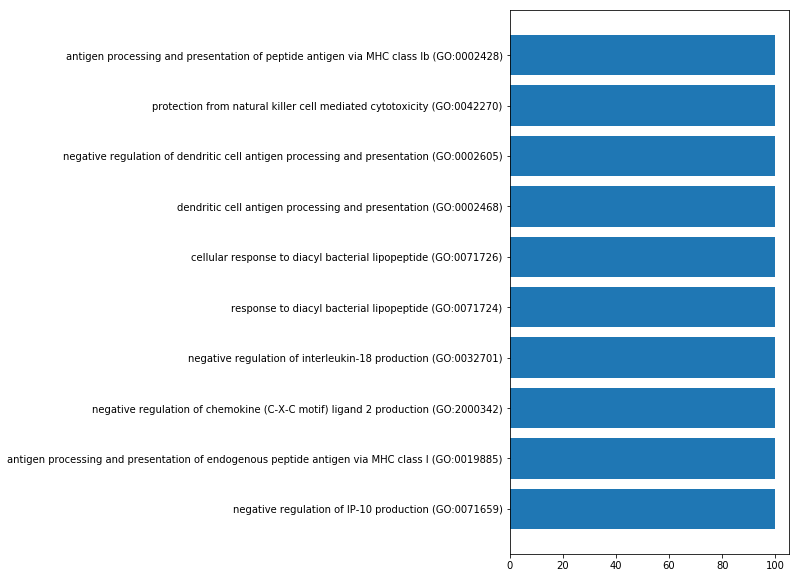

In [139]:
fig, ax = plt.subplots(figsize=(5,10))
plt.barh(go1_plot["GO biological process complete"],go1_plot["upload_1 (fold Enrichment)"].tolist())
plt.savefig("../plots/fig1/group1_go.bar.pdf")

In [140]:
go2_plot=go2.sort_values(by="upload_1 (fold Enrichment)",ascending=False).iloc[0:10]

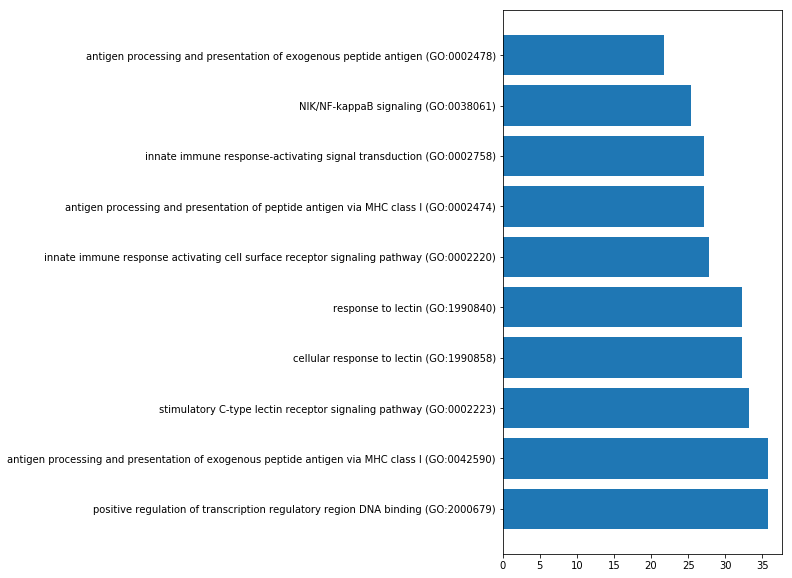

In [141]:
fig, ax = plt.subplots(figsize=(5,10))
plt.barh(go2_plot["GO biological process complete"],go2_plot["upload_1 (fold Enrichment)"].tolist())
plt.savefig("../plots/fig1/group2_go.bar.pdf")

### run analysis by cancer type

In [142]:
canc = pd.read_csv("/cellar/controlled/dbgap-genetic/phs000178_TCGA/birdseed-processing/gtype.meta", delimiter="\t", header=None)

pancanatlas_gcta=pancanatlas[gcta_genes]

#df variance explained
pc1_variance=[]
cancer_type=[]

df_loadings=pd.DataFrame()

for x in canc[0].unique():
    try:
        #get proportion explained by PC1
        ids=canc[canc[0]==x][2].tolist()
        canc_gcta=pancanatlas_gcta[pancanatlas.index.isin(ids)]
        print(canc_gcta.shape)
        canc_pca, canc_var, canc_loadings=pca(canc_gcta)
        pc1_variance.append(canc_var["PC1"])
        cancer_type.append(x)
    
        canc_loadings["cancer"]=x
        df_loadings=df_loadings.append(canc_loadings)
        
        
    except:
        pass


(69, 157)
(77, 157)
(122, 157)
(215, 157)
(131, 157)
(54, 157)
(197, 157)
(355, 157)
(189, 157)
(430, 157)
(143, 157)
(110, 157)
(404, 157)
(0, 157)
(174, 157)
(409, 157)
(353, 157)
(777, 157)
(432, 157)
(121, 157)
(78, 157)
(29, 157)
(0, 157)
(322, 157)
(128, 157)
(42, 157)
(387, 157)
(325, 157)
(160, 157)
(317, 157)
(0, 157)
(218, 157)
(92, 157)


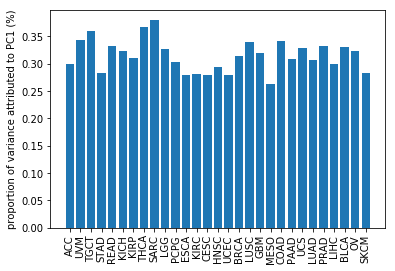

In [143]:
pc1_var=pd.DataFrame({"cancer":cancer_type,"PC1 variance":pc1_variance})
plt.bar(pc1_var["cancer"],pc1_var["PC1 variance"])
plt.xticks(rotation=90)
plt.ylabel("proportion of variance attributed to PC1 (%)")
plt.savefig("../plots/fig1/pc1.var.explained.pdf")

In [144]:
df_loadings=df_loadings.reset_index()
df_loadings["PC1"]=abs(df_loadings["PC1"])
top_loadings=gcta_loadings.sort_values(by="PC1",ascending=False).index.tolist()[:10]
df_loadings=df_loadings[df_loadings["index"].isin(top_loadings)]

In [145]:
mp_var=dict(zip(gcta_loadings.index.tolist(),gcta_loadings["PC1"].tolist()))
df_loadings["var"]=df_loadings["index"].map(mp_var)
df_loadings["index"]=df_loadings["index"]+"\n("+df_loadings["var"].round(2).astype(str)+")"

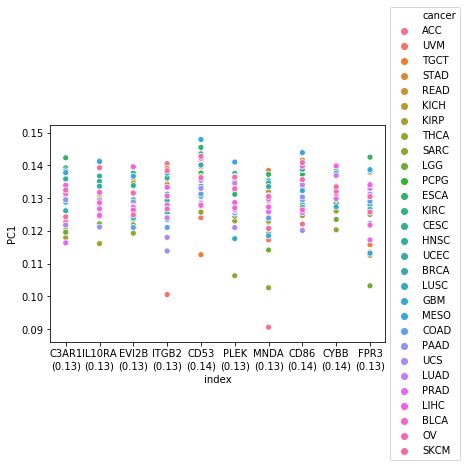

In [146]:
ax=sns.scatterplot(x="index",y="PC1",hue="cancer",data=df_loadings)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("../plots/fig1/pc1.cancer.loadings.pdf")